In [1]:
from typing import List

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np
import pandas as pd

from plasticc.dataset import Dataset

/home/kk385830/miniconda3/envs/plasticc/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
ds_tsfresh = Dataset('../data/sets/tsfresh-sample/', y_colname='target')

In [3]:
ds_simple = Dataset('../data/sets/simple-12-01/', y_colname='target')

In [4]:
Xt, yt = ds_tsfresh.train

In [5]:
Xs, ys = ds_simple.train

### Eliminate null values

In [6]:
def null_values(X: pd.DataFrame) -> List[str]:
    print("Total columns:", len(X.columns))
    na_cols = [col for col in X.columns if X[col].isna().any()]
    print("Total NA columns: ", len(na_cols))
    if len(na_cols) < 10:
        print("NA values by column:")
        print({na_col: X[na_col].isna().sum() for na_col in na_cols})
    return na_cols

In [7]:
na_tsfresh = null_values(Xt)

Total columns: 1065
Total NA columns:  1
NA values by column:
{'distmod': 2325}


In [8]:
na_simple = null_values(Xs)

Total columns: 176
Total NA columns:  1
NA values by column:
{'distmod': 2325}


We will fill null values with 0 and remove values that were duplicated

In [9]:
for X in [Xs, Xt]:
    X.fillna(0, inplace=True)
#     X.dropna(axis=1, inplace=True)
    assert(X.notna().all().all())
    X.drop(columns=[col for col in set(X.columns) if col.endswith('_meta')], inplace=True)

### Eliminate inifinte values

In [10]:
for X in [Xs, Xt]:
    print("Before infinity removal:", X.shape)
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    na_cols = null_values(X)
    X.drop(columns=na_cols, inplace=True)
    print("After infinity removal:", X.shape)

Before infinity removal: (7848, 176)
Total columns: 176
Total NA columns:  0
NA values by column:
{}
After infinity removal: (7848, 176)
Before infinity removal: (7848, 1064)
Total columns: 1064
Total NA columns:  0
NA values by column:
{}
After infinity removal: (7848, 1064)


### Train models on simple dataset

In [11]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
def plot_feature_importances(model, feature_names: List[str]):
    features = pd.DataFrame({"Importance": model.feature_importances_, "Feature": feature_names})
    fig, ax = plt.subplots(figsize=(6,15))
    sns.barplot(ax=ax, x='Importance', y='Feature', data=features.sort_values(by='Importance', ascending=False).head(50))
    sns.despine(left=True, bottom=True)
    plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.15, random_state=42)

In [16]:
xgb_model = XGBClassifier(
    objective='multi:softmax', 
    num_class=14, 
    learning_rate=0.03, 
    subsample=0.9, 
    colsample_bytree=0.5, 
    reg_alpha=0.01, 
    reg_lambda=0.01, 
    min_child_weight=10, 
    n_estimators=1024, 
    max_depth=3, 
    nthread=16
)

In [17]:
# TODO: Class weights for training and for eval

In [18]:
%%time
xgb_model.fit(X_train, y_train, verbose=100, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='mlogloss', early_stopping_rounds=50)

[0]	validation_0-mlogloss:2.55162	validation_1-mlogloss:2.55334
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 50 rounds.
[100]	validation_0-mlogloss:0.860256	validation_1-mlogloss:0.907671
[200]	validation_0-mlogloss:0.635665	validation_1-mlogloss:0.733654
[300]	validation_0-mlogloss:0.534223	validation_1-mlogloss:0.681871
[400]	validation_0-mlogloss:0.470507	validation_1-mlogloss:0.66156
[500]	validation_0-mlogloss:0.422318	validation_1-mlogloss:0.651293
[600]	validation_0-mlogloss:0.381903	validation_1-mlogloss:0.645966
[700]	validation_0-mlogloss:0.347635	validation_1-mlogloss:0.640294
[800]	validation_0-mlogloss:0.31718	validation_1-mlogloss:0.637786
[900]	validation_0-mlogloss:0.291347	validation_1-mlogloss:0.637063
Stopping. Best iteration:
[890]	validation_0-mlogloss:0.293664	validation_1-mlogloss:0.63679

CPU times: user 9min 47s, sys: 152 ms, total: 9min 47s
Wall time:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=3, min_child_weight=10, missing=None, n_estimators=1024,
       n_jobs=1, nthread=16, num_class=14, objective='multi:softprob',
       random_state=0, reg_alpha=0.01, reg_lambda=0.01, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9)

In [21]:
xgb_model.score(X_test, y_test)

0.7775891341256367

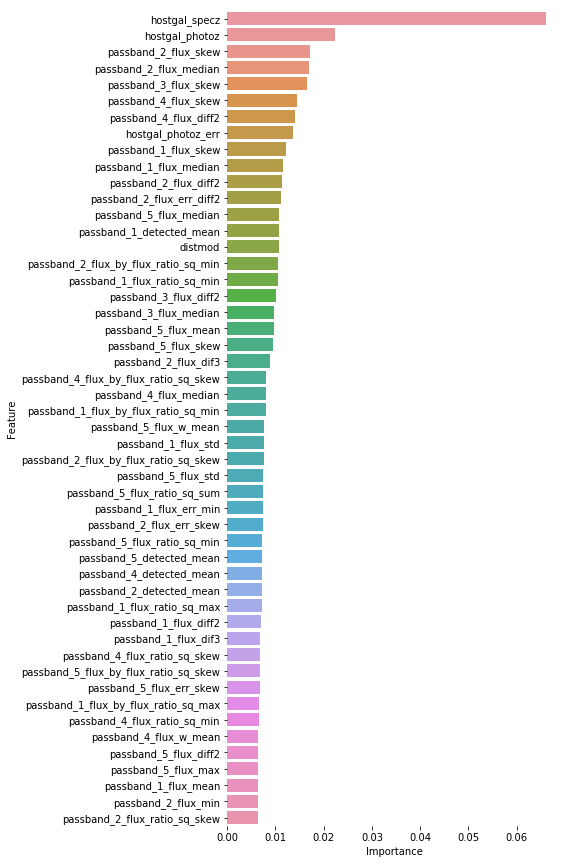

In [23]:
plot_feature_importances(xgb_model, X_test.columns)

### Train model on tsfresh dataset

In [24]:
#TODO

### Calculate feature imporatnce for selecting optimal tsfresh features

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import describe
import tsfresh
import pandas as pd

In [35]:
def to_tsfresh_format(feature_set: set, train_X: pd.DataFrame) -> dict:
    """ Converts a set of features names into tsfresh-acceptable settings dict. """
    df_selected = train_X[list(feature_set)]
    return tsfresh.feature_extraction.settings.from_columns(df_selected)

def select_features_from_trained_model(model, train_X: pd.DataFrame, meta_columns: set, verbose=True) -> set:
    """
    Extracts a set of relevant features from trained model.
    Parameters:
    - train_X should be the X used to train the model
    - meta_columns should contain column names that will be excluded from the tsfresh selection (columns from metadata, not the time series)
    """
    print(describe(model.feature_importances_))
    features = pd.Series(model.feature_importances_, index=train_X.columns)
    print("Most relevant features for the model:", features.sort_values().tail(10))
    # calculating how much data is lost based on minimal importance level
    N_THRESHOLDS = 1000
    select_crit = np.zeros(N_THRESHOLDS)
    select_min = np.zeros(N_THRESHOLDS)
    for i, q in enumerate(np.linspace(features.min(), features.max(), N_THRESHOLDS, endpoint=False)):
        selected = features[features > q]
        select_crit[i] = selected.min() * len(selected) / len(features)
        select_min[i] = selected.min()
    # choosing minimum importance level that maximizes (selected feature count * minimal selected feature importance)
    min_importance = select_min[np.argmax(select_crit)]
    selected_features = set(features[features > min_importance].index) - meta_columns
    if verbose:
        print(f"Selected minimal importance: {min_importance}", f"Number of selected features: {len(selected_features)}")
        plt.plot(select_crit)
        plt.show()
    return selected_features, features

In [36]:
meta_columns = set(Dataset('../data/sets/base/').train_meta.columns)

DescribeResult(nobs=1063, minmax=(0.0, 0.12809652), mean=0.00094073376, variance=1.7136652e-05, skewness=27.461490631103516, kurtosis=836.4666759335174)
Most relevant features for the model: 5__abs_energy                            0.006418
4__fft_aggregated__aggtype_"kurtosis"    0.007316
hostgal_photoz                           0.007830
2__fft_aggregated__aggtype_"kurtosis"    0.008215
1__abs_energy                            0.008985
4__skewness                              0.010782
1__skewness                              0.011167
3__skewness                              0.014376
2__skewness                              0.016814
hostgal_specz                            0.128097
dtype: float32
Selected minimal importance: 0.0008984726155176759 Number of selected features: 274


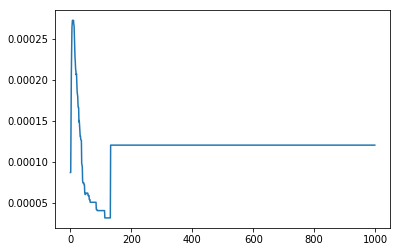

In [37]:
xgb_fset, xgb_feature_importance = select_features_from_trained_model(model1, X, meta_columns)

DescribeResult(nobs=1063, minmax=(0.0, 0.045006083722017746), mean=0.0009407337723424271, variance=5.165210235765588e-06, skewness=11.532354823143152, kurtosis=178.22540690042794)
Most relevant features for the model: 4__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0    0.007598
2__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.0    0.009486
2__quantile__q_0.1                                               0.010711
2__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0    0.010874
2__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0    0.011374
3__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0    0.018506
2__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.0     0.020175
hostgal_specz                                                    0.025541
hostgal_photoz_err                                               0.029981
hostgal_photoz                                                   0.045006
dtype: float64
Selected minimal importance

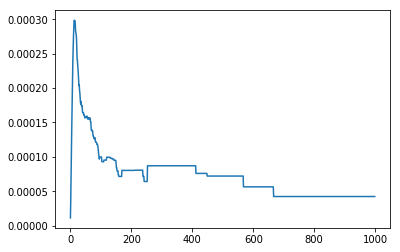

In [38]:
skl_fset, skl_feature_importance = select_features_from_trained_model(model2, X, meta_columns)

In [39]:
important_for_both = xgb_fset & skl_fset

In [40]:
len(important_for_both)

222

In [41]:
common_dict = to_tsfresh_format(important_for_both, X)

In [42]:
type(common_dict)

dict

#### Decrease number of features
There are some inconsistencies when it comes to which features are extracted for which series.
We will limit extracted features to those relevant for most of the 6 series for now.

In [43]:
keyset = set()
for i in range(6):
    keyset |= set(common_dict[str(i)].keys())

In [44]:
len(keyset)

17

In [45]:
feature_counts = dict()
for feature in keyset:
    for i in range(6):
        for key in common_dict[str(i)].keys():
            if feature in key:
                try:
                    feature_counts[feature] += 1
                except KeyError:
                    feature_counts[feature] = 1

In [46]:
feature_counts = pd.Series(feature_counts)

In [54]:
feature_counts.sort_values(ascending=False)

quantile                             12
autocorrelation                      12
abs_energy                            6
fft_coefficient                       6
linear_trend                          6
ratio_beyond_r_sigma                  6
change_quantiles                      6
agg_autocorrelation                   6
energy_ratio_by_chunks                6
cid_ce                                6
time_reversal_asymmetry_statistic     5
maximum                               5
c3                                    5
mean                                  5
skewness                              5
fft_aggregated                        5
approximate_entropy                   5
dtype: int64

In [48]:
feature_counts.sort_values(ascending=False).mean()

6.294117647058823

In [49]:
final_features = set(feature_counts[feature_counts > 4].index)

In [50]:
final_features

{'abs_energy',
 'agg_autocorrelation',
 'approximate_entropy',
 'autocorrelation',
 'c3',
 'change_quantiles',
 'cid_ce',
 'energy_ratio_by_chunks',
 'fft_aggregated',
 'fft_coefficient',
 'linear_trend',
 'maximum',
 'mean',
 'quantile',
 'ratio_beyond_r_sigma',
 'skewness',
 'time_reversal_asymmetry_statistic'}

### Save feature dict for tsfresh feature generator to use

In [51]:
import pickle

from tsfresh.feature_extraction.settings import ComprehensiveFCParameters

In [52]:
settings = ComprehensiveFCParameters()
comprehensive_keys = set(settings.keys())
for key in comprehensive_keys:
    if key not in final_features:
        del settings[key]

In [53]:
with open('../data/config/tsfresh-settings.pkl', 'wb+') as file:
    pickle.dump(settings, file)

In [55]:
model1.classes_

array([ 6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95])